# Assignment 1: Time Series Forecast With Python (Seasonal ARIMA)

**Lecturer**: Vincent Claes<br>
**Authors:** Bryan Honof, Jeffrey Gorissen<br>
**Start Date:** 19/10/2018
    
**Objective:** Visualize and predict the future temperatures via ARIMA

**Description:** In this notebook we take a close look at the data

## Table of contents

1. [Import libraries](#Import-Libraries)
2. [Load in the data](#load-data)
3. [Wrange the data](#)
4. [A bit of Exploratory Data Analysis (EDA)](#EDA) 

## 1. Import Libraries <a name="Import-Libraries"></a>

In [1]:
import warnings

import numpy             as np
import pandas            as pd
import seaborn           as sns
import itertools         as it
import statsmodels.api   as sm
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal      import seasonal_decompose
from statsmodels.tsa.stattools     import adfuller
from statsmodels.tsa.stattools     import acf, pacf
from statsmodels.tsa.arima_model   import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import itertools

warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

## 2. Load in the data <a name="load-data"></a>

In [2]:
data_csv = pd.read_csv('./data/data.csv')

In [3]:
data_csv.tail(5)

,dateTime,temperature
330,2018-11-24 17:00:00,14.925000
331,2018-11-24 18:00:00,15.327500
332,2018-11-24 19:00:00,15.502500
333,2018-11-24 20:00:00,16.665000
334,2018-11-24 21:00:00,17.323333


In [4]:
data_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 335 entries, 0 to 334
Data columns (total 2 columns):
dateTime       335 non-null object
temperature    335 non-null float64
dtypes: float64(1), object(1)
memory usage: 5.3+ KB


## 3. Wrangle the Data <a name="Wrangle-the-Data"></a>

Since we want our dataframe to be a time series we will have to convert our index because, at this moment it is not a ```datetimeIndex```.<br>
We can do this with the help of the ```pandas``` methods ```to_datetime()``` and ```set_index```.

In [5]:
data = pd.DataFrame()

# Convert the creation_date column to datetime64
data['dateTime'] = pd.to_datetime(data_csv['dateTime'])
# Convert the value column to float
data['temperature'] = pd.to_numeric(data_csv['temperature'])

# Set the dateTime column as index
data = data.set_index(['dateTime'])

# Sort the dataFrame just to be sure...
data = data.sort_index()

# Double check the results
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 335 entries, 2018-11-10 23:00:00 to 2018-11-24 21:00:00
Data columns (total 1 columns):
temperature    335 non-null float64
dtypes: float64(1)
memory usage: 5.2 KB


As we can see we successfully convert our index to a ```datetimeIndex``` thus making it a time series dataframe.

## 4. A bit of Exploratory Data Analysis (EDA) <a name="EDA"></a>

<Figure size 432x288 with 0 Axes>

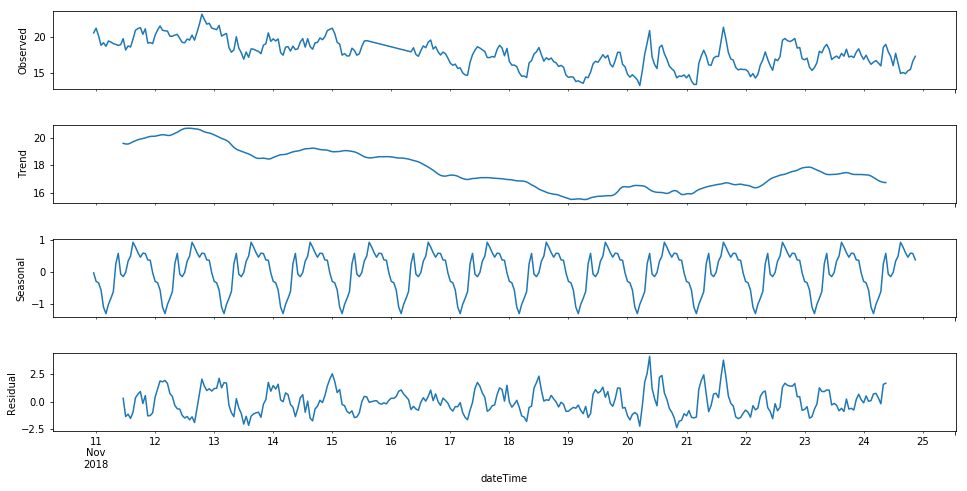

In [6]:
decomposition = seasonal_decompose(data)  
fig = plt.figure()
fig = decomposition.plot()
fig.set_size_inches(15, 8)

In [7]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

#run overnight with 
#p = d = q = range(0, 4)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 24) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))


Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 24)
SARIMAX: (0, 0, 1) x (0, 1, 0, 24)
SARIMAX: (0, 1, 0) x (0, 1, 1, 24)
SARIMAX: (0, 1, 0) x (1, 0, 0, 24)


In [9]:
#warnings.filterwarnings("ignore") # specify to ignore warning messages

best_aic = np.inf 
best_param = None
best_seasonal = None
best_mod = None


for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            temp_mod = sm.tsa.statespace.SARIMAX(data,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False,
                                            freq='H')
            results = temp_mod.fit()
           
            
            temp_aic = results.aic
            if temp_aic < best_aic:
                best_aic = temp_aic
                best_param = param
                best_seasonal = param_seasonal
                best_mod = temp_mod
                
        except:
            continue
            
            #results = mod.fit()

print('Best model: ARIMA{}x{}24 - AIC:{}'.format(best_param, best_seasonal, best_aic))

/home/bryan/.conda/envs/pxl/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/bryan/.conda/envs/pxl/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/bryan/.conda/envs/pxl/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/bryan/.conda/envs/pxl/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Best model: ARIMA(1, 1, 1)x(0, 1, 1, 24)12 - AIC:733.4976569258329


In [11]:
mod = sm.tsa.statespace.SARIMAX(data,
                                order=(1, 1, 1),
                                seasonal_order=(0, 1, 1, 24),
                                enforce_stationarity=False,
                                enforce_invertibility=False,
                                freq='H')

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8063      0.040     20.282      0.000       0.728       0.884
ma.L1         -1.0309      0.027    -38.826      0.000      -1.083      -0.979
ma.S.L24      -0.8444      0.051    -16.574      0.000      -0.944      -0.745
sigma2         0.6654      0.067      9.858      0.000       0.533       0.798


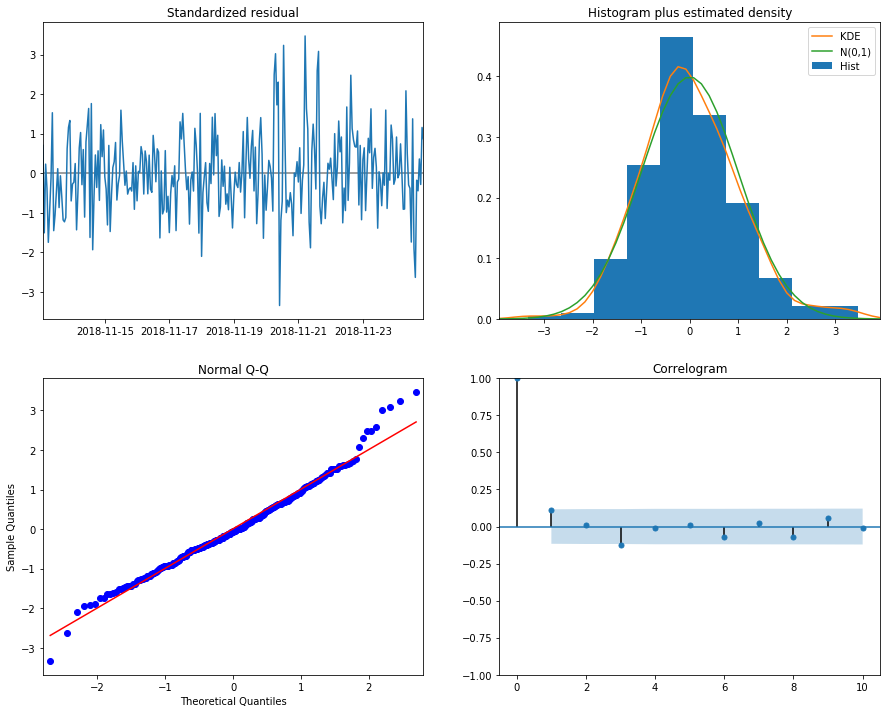

In [12]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [17]:
pred = results.get_prediction()
pred_ci = pred.conf_int()

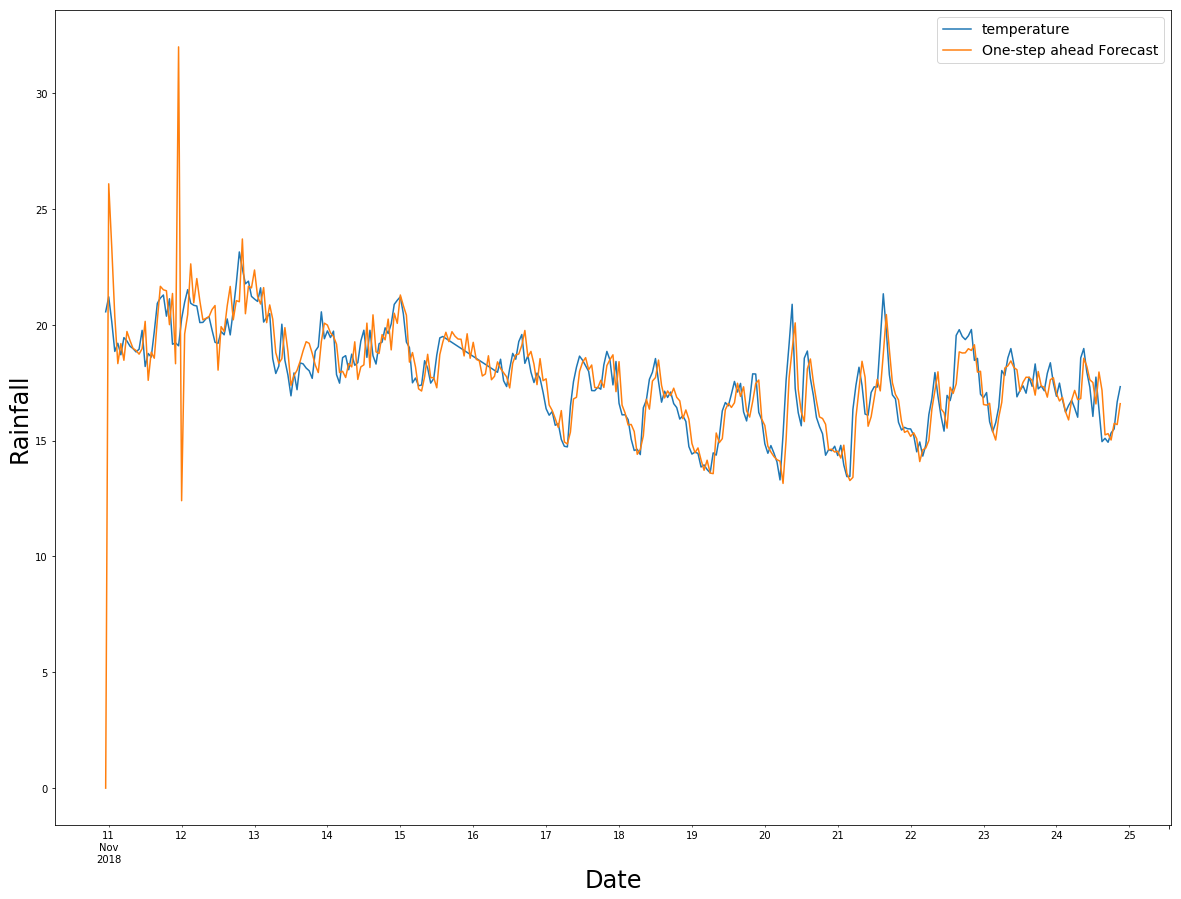

In [22]:
ax = data.plot(label='Observed', figsize=(20, 15))
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast')

#ax.fill_between(pred_ci.index,
#                pred_ci.iloc[:, 0],
#                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date', fontsize = 24)
ax.set_ylabel('Rainfall', fontsize = 24)
plt.legend(fontsize = 14)

plt.show()